In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, metrics
import tensorflow as tf
from tensorflow.python.framework import ops
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

%matplotlib inline
np.random.seed(1)

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'bee_dataset/bee_dataset_150',
    split= ['train[:70%]', 'train[70%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
#tfds.show_examples(ds_train, ds_info)


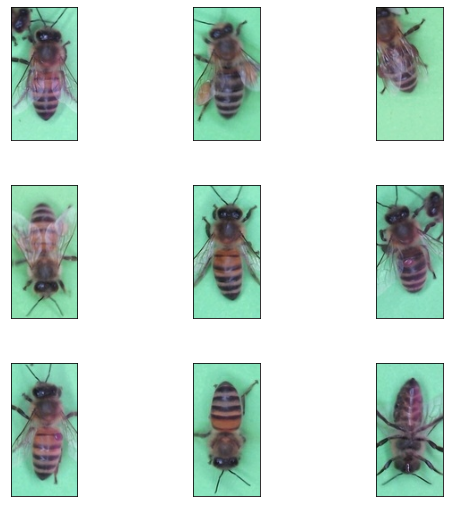

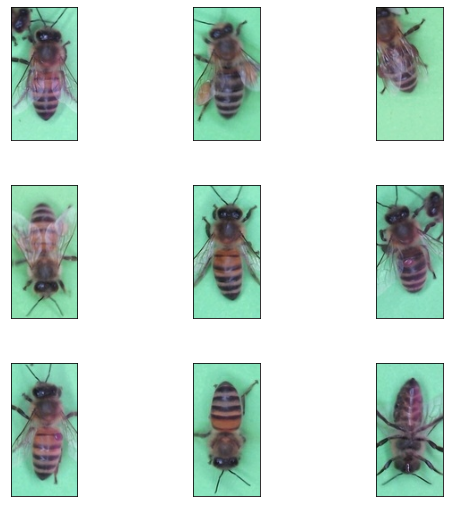

In [ ]:
tfds.show_examples(ds_train, ds_info)

,Image,Cooling the hive,Carrying pollen-packets,Varroa infected,Wasp
0,,0.0,0.0,0.0,0.0
1,,0.0,1.0,0.0,0.0
2,,0.0,1.0,0.0,0.0
3,,0.0,1.0,0.0,0.0
4,,0.0,0.0,0.0,0.0
5,,0.0,0.0,1.0,0.0
6,,0.0,0.0,1.0,0.0
7,,1.0,0.0,0.0,0.0
8,,0.0,0.0,0.0,0.0
9,,0.0,0.0,1.0,0.0

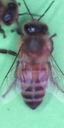
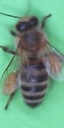
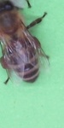
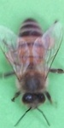
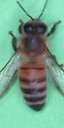
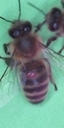
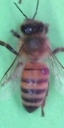
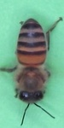
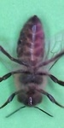
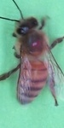

In [ ]:
df = tfds.as_dataframe(ds_train.take(10), ds_info)
df.columns = ['Image', 
              'Cooling the hive', 
              'Carrying pollen-packets', 
              'Varroa infected',
              'Wasp'
              ]
df

In [ ]:
df = tfds.as_dataframe(ds_train.take(ds_info.splits['train'].num_examples), ds_info)
df.columns = ['Image', 
              'Cooling the hive', 
              'Carrying pollen-packets', 
              'Varroa infected',
              'Wasp'
              ]
df = df.drop(columns=['Image'])
df.info()              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5243 entries, 0 to 5242
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cooling the hive         5243 non-null   float64
 1   Carrying pollen-packets  5243 non-null   float64
 2   Varroa infected          5243 non-null   float64
 3   Wasp                     5243 non-null   float64
dtypes: float64(4)
memory usage: 164.0 KB


In [ ]:
cooling_hive = df['Cooling the hive'].sum()
pollen = df['Carrying pollen-packets'].sum()
infected = df['Varroa infected'].sum()
wasps = df['Wasp'].sum()
number_of_training_examples = len(df)
none_of_them = number_of_training_examples - (cooling_hive+pollen+infected+wasps)
print('Number of positive examples in class 1: {}'.format(int(cooling_hive)))
print('Number of positive examples in class 2: {}'.format(int(pollen)))
print('Number of positive examples in class 3: {}'.format(int(infected)))
print('Number of positive examples in class 4: {}'.format(int(wasps)))
print('Number of examples that do not belong to any class: {}'.format(int(none_of_them)))

Number of positive examples in class 1: 798
Number of positive examples in class 2: 736
Number of positive examples in class 3: 892
Number of positive examples in class 4: 686
Number of examples that do not belong to any class: 2131


In [ ]:
class_sum = df.sum(axis='index')
class_sum.head(30)

Cooling the hive           798.0
Carrying pollen-packets    736.0
Varroa infected            892.0
Wasp                       686.0
dtype: float64

In [ ]:
multi_sum = df.sum(axis='columns')
count3 = multi_sum[multi_sum >2].count()
count2 = multi_sum[multi_sum >1].count() - count3
count1 = multi_sum[multi_sum ==1.0].count()
print('Number of examples having positive labels in 2 classes at the same time: {}'.format(count2))
print('Number of examples having positive labels in 3 classes at the same time: {}'.format(count3))
print('Number of examples having positive label only in 1 class: {}'.format(count1))

Number of examples having positive labels in 2 classes at the same time: 117
Number of examples having positive labels in 3 classes at the same time: 1
Number of examples having positive label only in 1 class: 2875


In [ ]:
multi_index =  multi_sum < 2
np.shape(multi_index)
df_single_class_label = df[multi_index]
df_single_class_label.sum(axis = 'index')

Cooling the hive           681.0
Carrying pollen-packets    659.0
Varroa infected            850.0
Wasp                       685.0
dtype: float64

In [ ]:
def transform_data(image, label):
  labels = tuple(label.values())
  
  return tf.image.resize(image, (50,25)), labels


ds_train = ds_train.map(
    transform_data, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)

ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


In [ ]:
ds_test = ds_test.map(
    transform_data, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [ ]:
# ds = ds_train.take(1)

# for image, label in ds:
#   print(image.shape, label.shape)


In [ ]:
def CNN_model(params):
    """
    Implements the forward propagation for the model:
    (CONV2D -> RELU -> MAXPOOL -> DROPOUT)*l times -> 
    -> FLATTEN -> (DENSE -> DROPOUT)*l times -> OUTPUT 
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model
    """   
    outputs_list= []
    X = []

    n_conv_layers = params['n_conv_layers']
    n_dense_layers = params['n_dense_layers']
    n_filters = params['n_filters']
    conv_kernels = params['conv_kernels']
    conv_strides = params['conv_strides']
    conv_padding = params['conv_padding']
    conv_activations = params['conv_activations']
    conv_dropout_rate = params['conv_dropout_rate']
    pool_kernels = params['pool_kernels']
    pool_strides = params['pool_strides']
    pool_padding = params['pool_padding']
    dense_activations = params['dense_activations']
    dense_dropout_rate = params['dense_dropout_rate']
    n_dense_units = params['n_dense_units']
    input_shape = params['input_shape']
    number_of_classes = params['number_of_classes']

    input_img = tf.keras.Input(shape=input_shape, name='inp')
    X = tf.keras.layers.Rescaling(1./255)(input_img)
    
    for l in range(n_conv_layers):

      X = tf.keras.layers.Conv2D(filters= n_filters[l], 
                                 kernel_size=conv_kernels[l], 
                                 strides = conv_strides[l], 
                                 padding=conv_padding[l], 
                                 activation=conv_activations[l])(X)    
      X = tf.keras.layers.MaxPool2D(pool_size=pool_kernels[l], 
                                    strides=pool_strides[l], 
                                    padding=pool_padding[l])(X)
      X = tf.keras.layers.Dropout(conv_dropout_rate[l])(X)

    X_f = tf.keras.layers.Flatten()(X)
    
    for c in range(number_of_classes):
        X = X_f
        for l in range((n_dense_layers-1)):
            X = tf.keras.layers.Dense(units = n_dense_units[l], 
                                     activation= dense_activations[l])(X)
            X = tf.keras.layers.Dropout(dense_dropout_rate[l])(X)
        X = tf.keras.layers.Dense(units= n_dense_units[-1], activation=dense_activations[-1], name=f'out_{c}')(X)
        outputs_list.append(X)

    outputs = outputs_list  # tf.stack(outputs_list)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model, params

In [ ]:
params1 = {'n_conv_layers':  3,
       'n_dense_layers': 4,
       'n_filters': [16, 32, 64],
       'conv_kernels': [(3,3), (3,3), (3,3)],
       'conv_strides': [(1,1), (1,1), (1,1)],
       'conv_padding' : ['valid','valid','valid'],
       'conv_activations' : ['relu', 'relu', 'relu'],
       'conv_dropout_rate' : [0.0, 0.1, 0.1],
       'pool_kernels' : [(2,2), (2,2), (2,2)],
       'pool_strides' : [(2,2), (2,2), (2,2)],
       'pool_padding' : ['valid','valid','valid'],
       'dense_activations' : ['relu', 'relu', 'relu', 'sigmoid'],
       'dense_dropout_rate' : [0.1, 0.0, 0.0, 0.0],
       'n_dense_units' : [64, 32, 16, 1],
       'input_shape' : (50, 25, 3),
       'number_of_classes': 4,
}

def create_metrics():
  return [tf.keras.metrics.BinaryAccuracy(name='bin_acc'), 
          tf.keras.metrics.Precision(name='prec'), 
          tf.keras.metrics.Recall(name='rec'), 
          tf.keras.metrics.TruePositives(name='TP'),
          tf.keras.metrics.TrueNegatives(name='TN'),
          tf.keras.metrics.FalsePositives(name='FP'),
          tf.keras.metrics.FalseNegatives(name='FN'),

          #tfa.metrics.MultiLabelConfusionMatrix(num_classes = 4)
        ]

metrics = []

for i in range( params1['number_of_classes']):
  metrics.append(create_metrics())

params_compile1 = {'optimizer': tf.keras.optimizers.Adam(0.001),
                   'loss': [tf.keras.losses.BinaryCrossentropy(from_logits=False)]* params1['number_of_classes'],
                   'metrics': metrics,
}

In [ ]:
cnn_model, current_params = CNN_model(params=params1)

for key, value in current_params.items():
    print(key, ' : ', value)
  
cnn_model.compile( 
    optimizer=params_compile1['optimizer'],
    loss=[params_compile1['loss']] * params1['number_of_classes'],
    metrics=params_compile1['metrics']
)

#for key, value in params_compile1.items():
#    print(key, ' : ', value)

cnn_model.summary()

n_conv_layers  :  3
n_dense_layers  :  4
n_filters  :  [16, 32, 64]
conv_kernels  :  [(3, 3), (3, 3), (3, 3)]
conv_strides  :  [(1, 1), (1, 1), (1, 1)]
conv_padding  :  ['valid', 'valid', 'valid']
conv_activations  :  ['relu', 'relu', 'relu']
conv_dropout_rate  :  [0.0, 0.1, 0.1]
pool_kernels  :  [(2, 2), (2, 2), (2, 2)]
pool_strides  :  [(2, 2), (2, 2), (2, 2)]
pool_padding  :  ['valid', 'valid', 'valid']
dense_activations  :  ['relu', 'relu', 'relu', 'sigmoid']
dense_dropout_rate  :  [0.1, 0.0, 0.0, 0.0]
n_dense_units  :  [64, 32, 16, 1]
input_shape  :  (50, 25, 3)
number_of_classes  :  4
Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp (InputLayer)               [(None, 50, 25, 3)]  0           []                               
                                                                                       

In [ ]:
cnn_model.fit(ds_train, epochs=400, validation_data=ds_test)

Epoch 1/400
41/41 [==============================] - 15s 180ms/step - loss: 1.8213 - out_0_loss: 0.4672 - out_1_loss: 0.4435 - out_2_loss: 0.4907 - out_3_loss: 0.4199 - out_0_bin_acc: 0.8392 - out_0_prec: 0.1642 - out_0_rec: 0.0138 - out_0_TP: 11.0000 - out_0_TN: 4389.0000 - out_0_FP: 56.0000 - out_0_FN: 787.0000 - out_1_bin_acc: 0.8596 - out_1_prec: 0.0000e+00 - out_1_rec: 0.0000e+00 - out_1_TP: 0.0000e+00 - out_1_TN: 4507.0000 - out_1_FP: 0.0000e+00 - out_1_FN: 736.0000 - out_2_bin_acc: 0.8112 - out_2_prec: 0.1689 - out_2_rec: 0.0280 - out_2_TP: 25.0000 - out_2_TN: 4228.0000 - out_2_FP: 123.0000 - out_2_FN: 867.0000 - out_3_bin_acc: 0.8692 - out_3_prec: 0.0000e+00 - out_3_rec: 0.0000e+00 - out_3_TP: 0.0000e+00 - out_3_TN: 4557.0000 - out_3_FP: 0.0000e+00 - out_3_FN: 686.0000 - val_loss: 1.6359 - val_out_0_loss: 0.4323 - val_out_1_loss: 0.3964 - val_out_2_loss: 0.4537 - val_out_3_loss: 0.3535 - val_out_0_bin_acc: 0.8474 - val_out_0_prec: 0.0000e+00 - val_out_0_rec: 0.0000e+00 - val_ou

In [ ]:
history_CM = cnn_model.history

In [ ]:
CM = history_CM.history['Multilabel_confusion_matrix']

In [ ]:
np.shape(CM)

In [ ]:
print(CM[-1])
print(CM[-2])
print(CM[-3])
print(CM[-4])

In [ ]:

X1_TP = history_CM.history['x1_true_positives_4']
X1_TN = history_CM.history['x1_true_negatives_4']
X1_FP = history_CM.history['x1_false_positives_4']
X1_FN = history_CM.history['x1_false_negatives_4']
Precision = history_CM.history['x1_precision_12']
Recall = history_CM.history['x1_recall_12']


print('X1_TP: ', X1_TP[70])
print('X1_TN: ', X1_TN[70])
print('X1_FP: ', X1_FP[70])
print('X1_FN: ', X1_FN[70])
print('Precision: ', Precision[70])
print('Recall: ', Recall[70])

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [ ]:
def plot_metrics(history):
  metrics=['out_0_loss','binary_accuracy', 'precision_5', 'recall_5']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'binary_accuracy':
      plt.ylim([0.75, plt.ylim()[1]])
    elif metric == 'precision_2':
      plt.ylim([0.5,1])
    elif metric == 'loss':
      plt.ylim([0.,0.6])
  
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
my_cnn_model15_history = cnn_model.history

In [ ]:
plot_metrics(my_cnn_model15_history)
#NO DROPOUT

In [ ]:
y_pred = cnn_model.predict(ds_train)

In [ ]:
true_y = np.concatenate([y for x, y in ds_train], axis=0)
np.array(true_y)

In [ ]:
y_pred_1 = y_pred >= 0.5
y_pred_0 = y_pred < 0.5
y_pred [y_pred_1] = 1.0
y_pred [y_pred_0] = 0.0


In [ ]:
t = true_y[:,1]
pr = y_pred[:,1]
print(t.shape)
print(pr.shape)

In [ ]:
print(true_y[50:71,2])
print(y_pred[50:71,2])

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score

In [ ]:
precision = []
recall = []
for l in range(4):
  p = precision_score(true_y[:,l], y_pred[:,l])
  r = recall_score(true_y[:,l], y_pred[:,l])
  precision.append(p)
  recall.append(r)
print('Precision per class: ', precision)
print('Recall per class: ', recall)
ConfusionMatrixDisplay.from_predictions(true_y[:,0], y_pred[:,0])
#ConfusionMatrixDisplay.from_predictions(true_labels[:,1], y_pred_rounded[:,1])
#ConfusionMatrixDisplay.from_predictions(true_labels[:,2], y_pred_rounded[:,2])
#ConfusionMatrixDisplay.from_predictions(true_labels[:,3], y_pred_rounded[:,3])

In [ ]:
cnn_model, current_params = CNN_model(params=params1)

for key, value in current_params.items():
    print(key, ' : ', value)

cnn_model.compile( 
    optimizer=params_compile1['optimizer'],
    loss=params_compile1['loss'],
    metrics=params_compile1['metrics']
)

#for key, value in params_compile1.items():
#    print(key, ' : ', value)

cnn_model.summary()

In [ ]:
cnn_model.fit(ds_train, epochs=40, validation_data=ds_test)

In [ ]:
my_cnn_model17_history = cnn_model.history

In [ ]:
plot_metrics(my_cnn_model17_history)
#WITH DROPOUT